# Sentiment Analysis in Classic Movie Reviews: Building a Predictive Model for The Film Now Union

## Project Statement

The Film Now Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Data Description

The data is stored in the imdb_reviews.tsv file. 

The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

Description of the selected fields:
review: the review text
pos: the target, '0' for negative and '1' for positive
ds_part: 'train'/'test' for the train/test part of dataset, correspondingly

## Initialization

In [7]:
import math
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [10]:
tqdm.pandas()

## Load Data

In [11]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [12]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [13]:
missing_values = df_reviews.isnull().sum()


In [14]:
# Function to clean text 
def clean_text(text):
    try:
        # Convert text to lowercase
        text = text.lower()
        # Remove punctuation and special characters
        text = re.sub(r'[^a-z0-9\s]', '', text)
        return text
    except Exception as e:
        return text

df_reviews['cleaned_review'] = df_reviews['review'].apply(clean_text)

In [15]:
missing_values, df_reviews.head()

(tconst             0
 title_type         0
 primary_title      0
 original_title     0
 start_year         0
 end_year           0
 runtime_minutes    0
 is_adult           0
 genres             0
 average_rating     2
 votes              2
 review             0
 rating             0
 sp                 0
 pos                0
 ds_part            0
 idx                0
 dtype: int64,
       tconst title_type primary_title original_title  start_year end_year  \
 0  tt0068152      movie             $              $        1971       \N   
 1  tt0068152      movie             $              $        1971       \N   
 2  tt0313150      short          '15'           '15'        2002       \N   
 3  tt0313150      short          '15'           '15'        2002       \N   
 4  tt0313150      short          '15'           '15'        2002       \N   
 
   runtime_minutes  is_adult              genres  average_rating  votes  \
 0             121         0  Comedy,Crime,Drama             6.3  

## EDA

Exploring the number of movies and reviews over years.

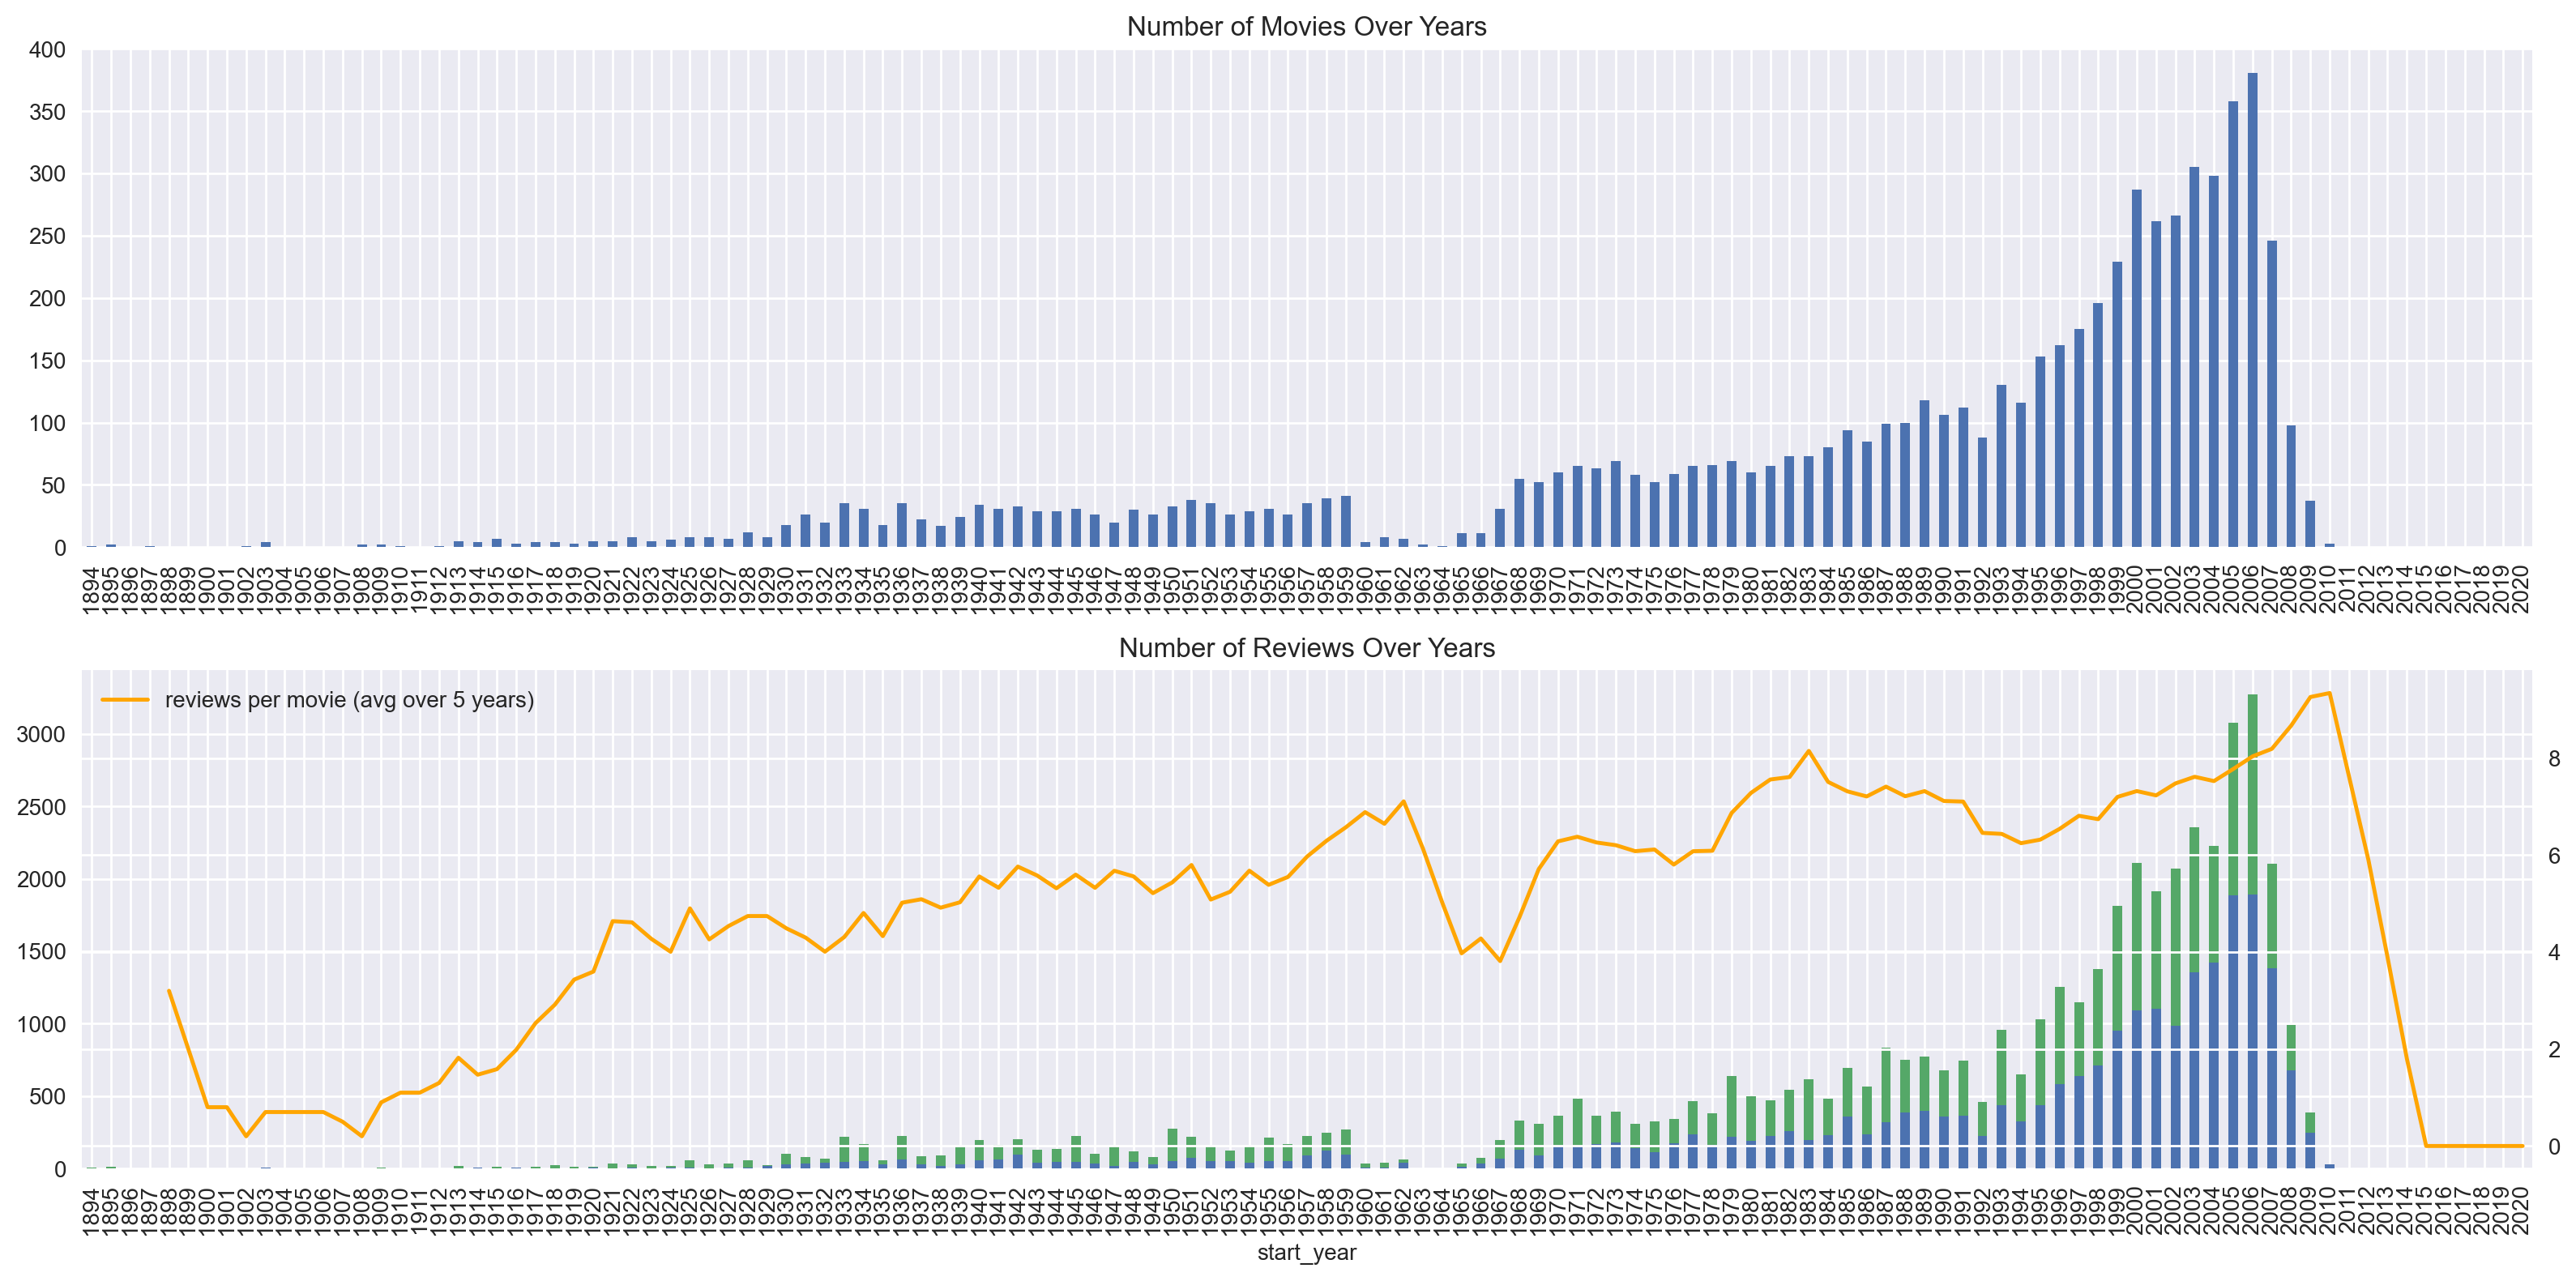

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Checking the distribution of number of reviews per movie with exact counting and KDE, to understand how it may differ from the exact counting.

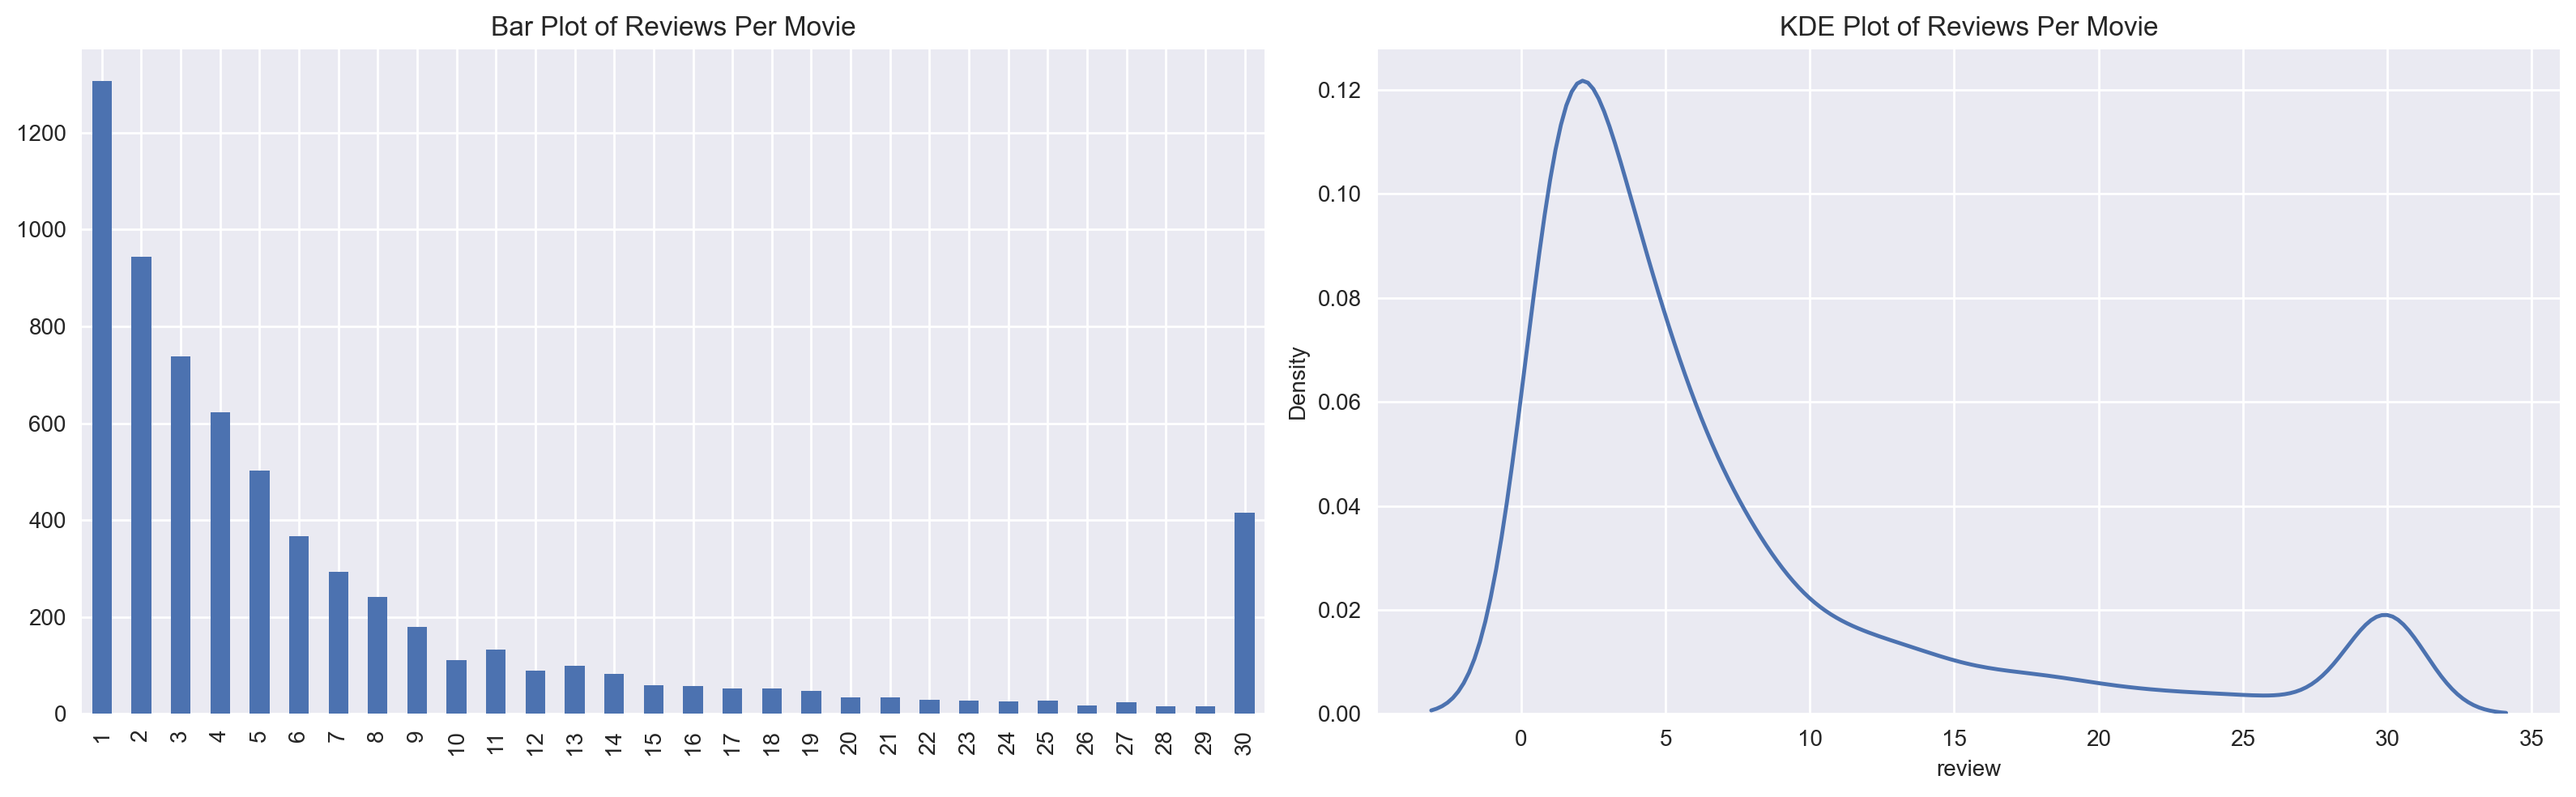

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of Reviews Per Movie')

fig.tight_layout()

In [18]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,47329.0,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,25562.917323,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,83670.039163,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


In [19]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

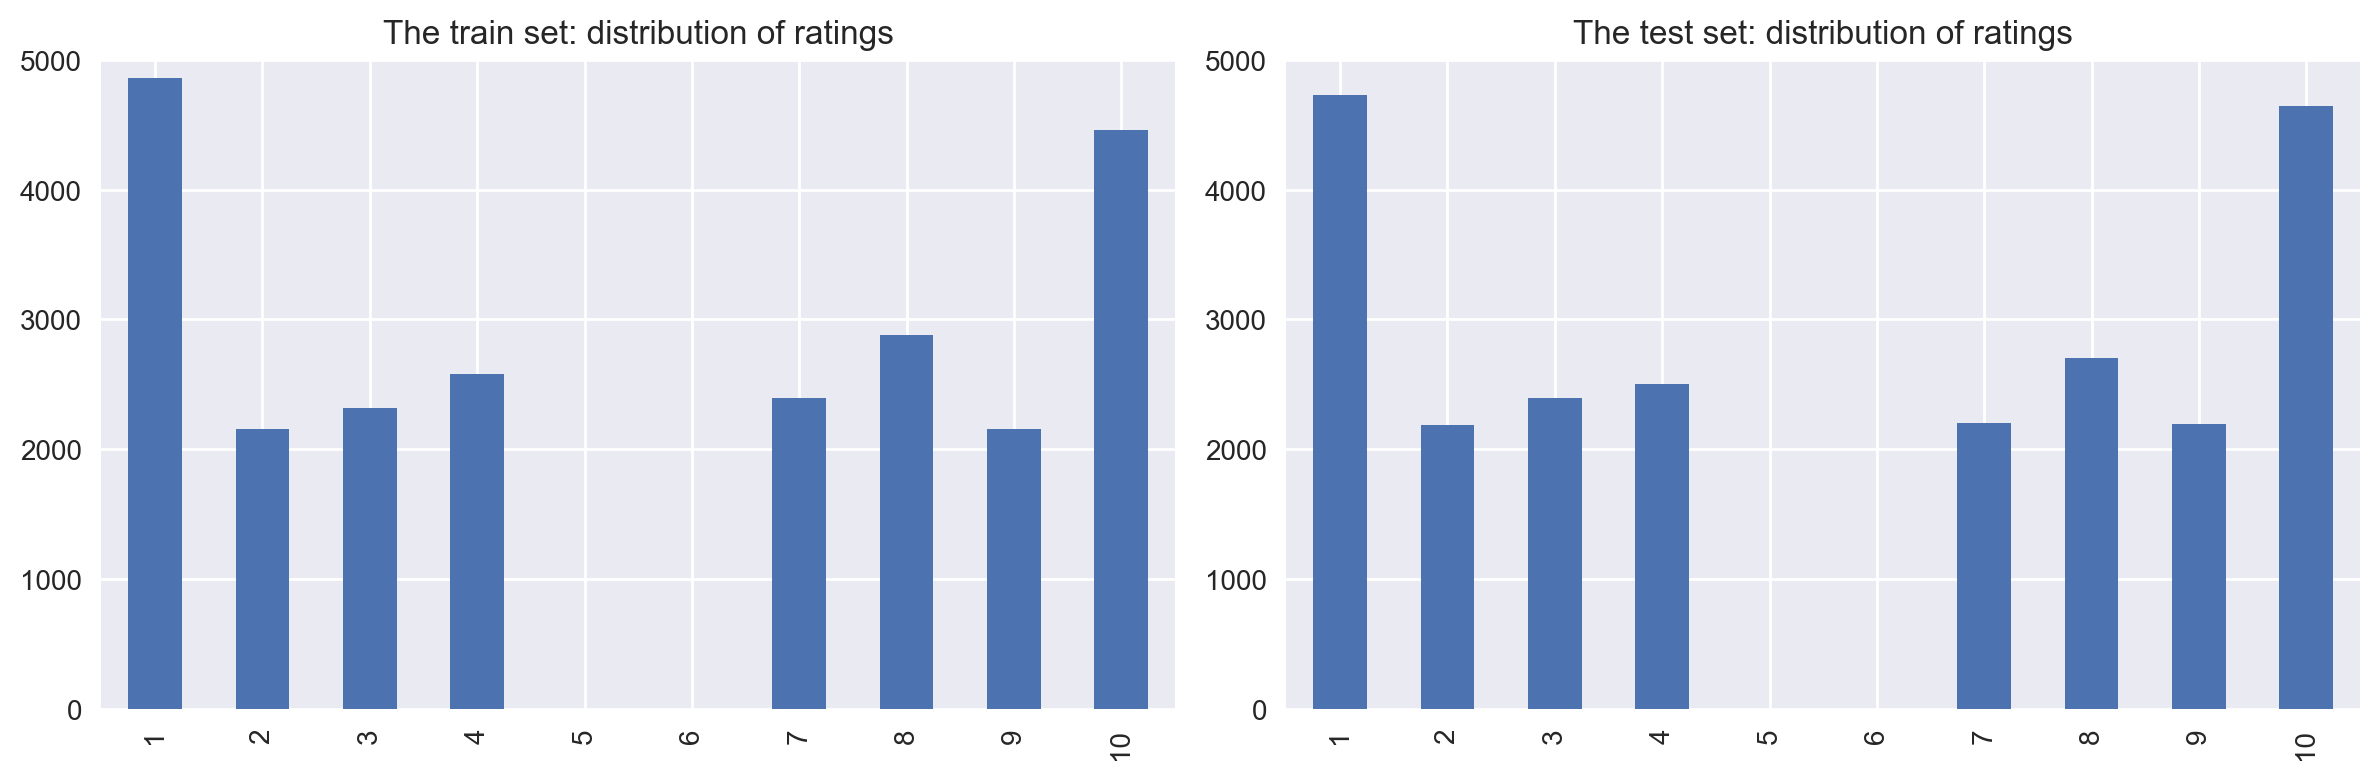

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset.

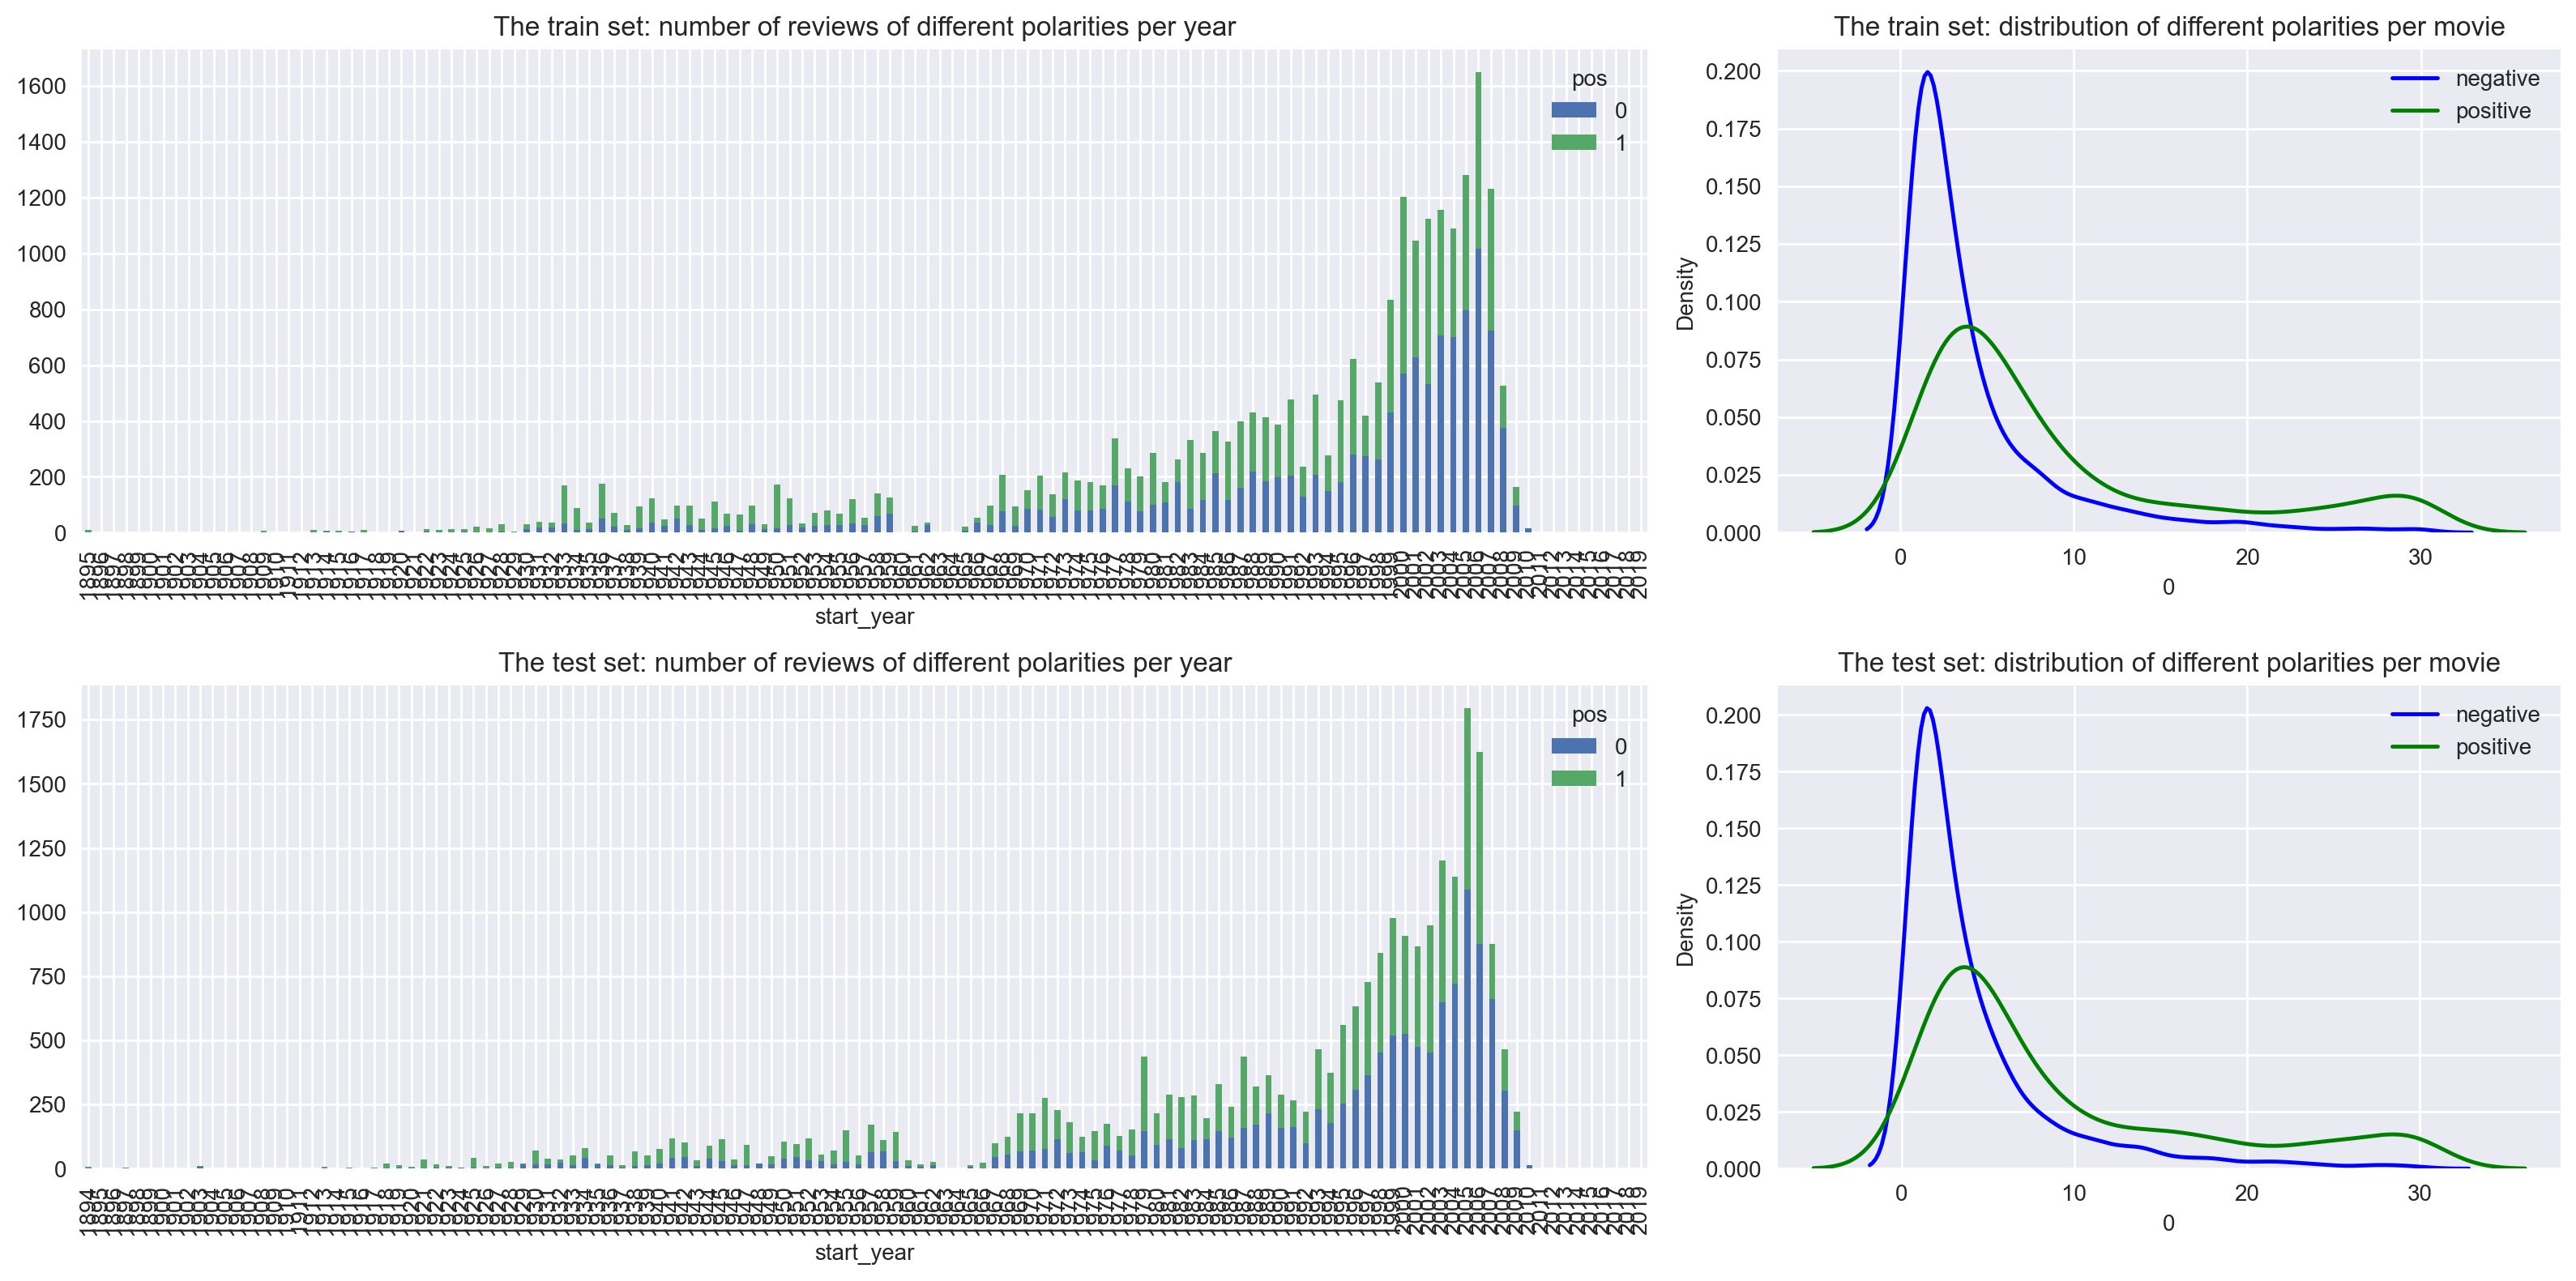

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Upper Plot - Number of Movies Over Years: This bar chart illustrates the number of movies released each year. The vertical bars increase in height towards more recent years, indicating a growth in the number of movies produced as time progresses. This trend suggests a significant expansion of the film industry or an increase in the documentation of films in recent decades.

Lower Plot - Number of Reviews Over Years: The bar chart shows the actual count of reviews per year, with each bar indicating the volume of reviews that movies from that year received. The line chart, which scales on the right y-axis, indicates the average number of reviews per movie, averaged over a 5-year period. This line chart shows an overall upward trend, suggesting that, on average, movies are receiving more reviews over time, which could be due to various factors such as the increased accessibility of review platforms or greater viewer engagement.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project.

In [22]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [23]:
df_reviews['review_norm'] = df_reviews['review'].apply(clean_text)

## Train / Test Split

In [24]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 19)
(23535, 19)


## Working with models

### Model 0 - Constant

In [25]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split



In [26]:
X = df_reviews['cleaned_review']  
y = df_reviews['pos']   

In [27]:
tfidf_vectorizer = TfidfVectorizer()

In [28]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train = tfidf_vectorizer.fit_transform(X_train_raw)

In [30]:
X_test = tfidf_vectorizer.transform(X_test_raw)

In [31]:
dummy_clf = DummyClassifier(strategy="most_frequent")

In [32]:
dummy_clf.fit(X_train, y_train)


DummyClassifier(strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


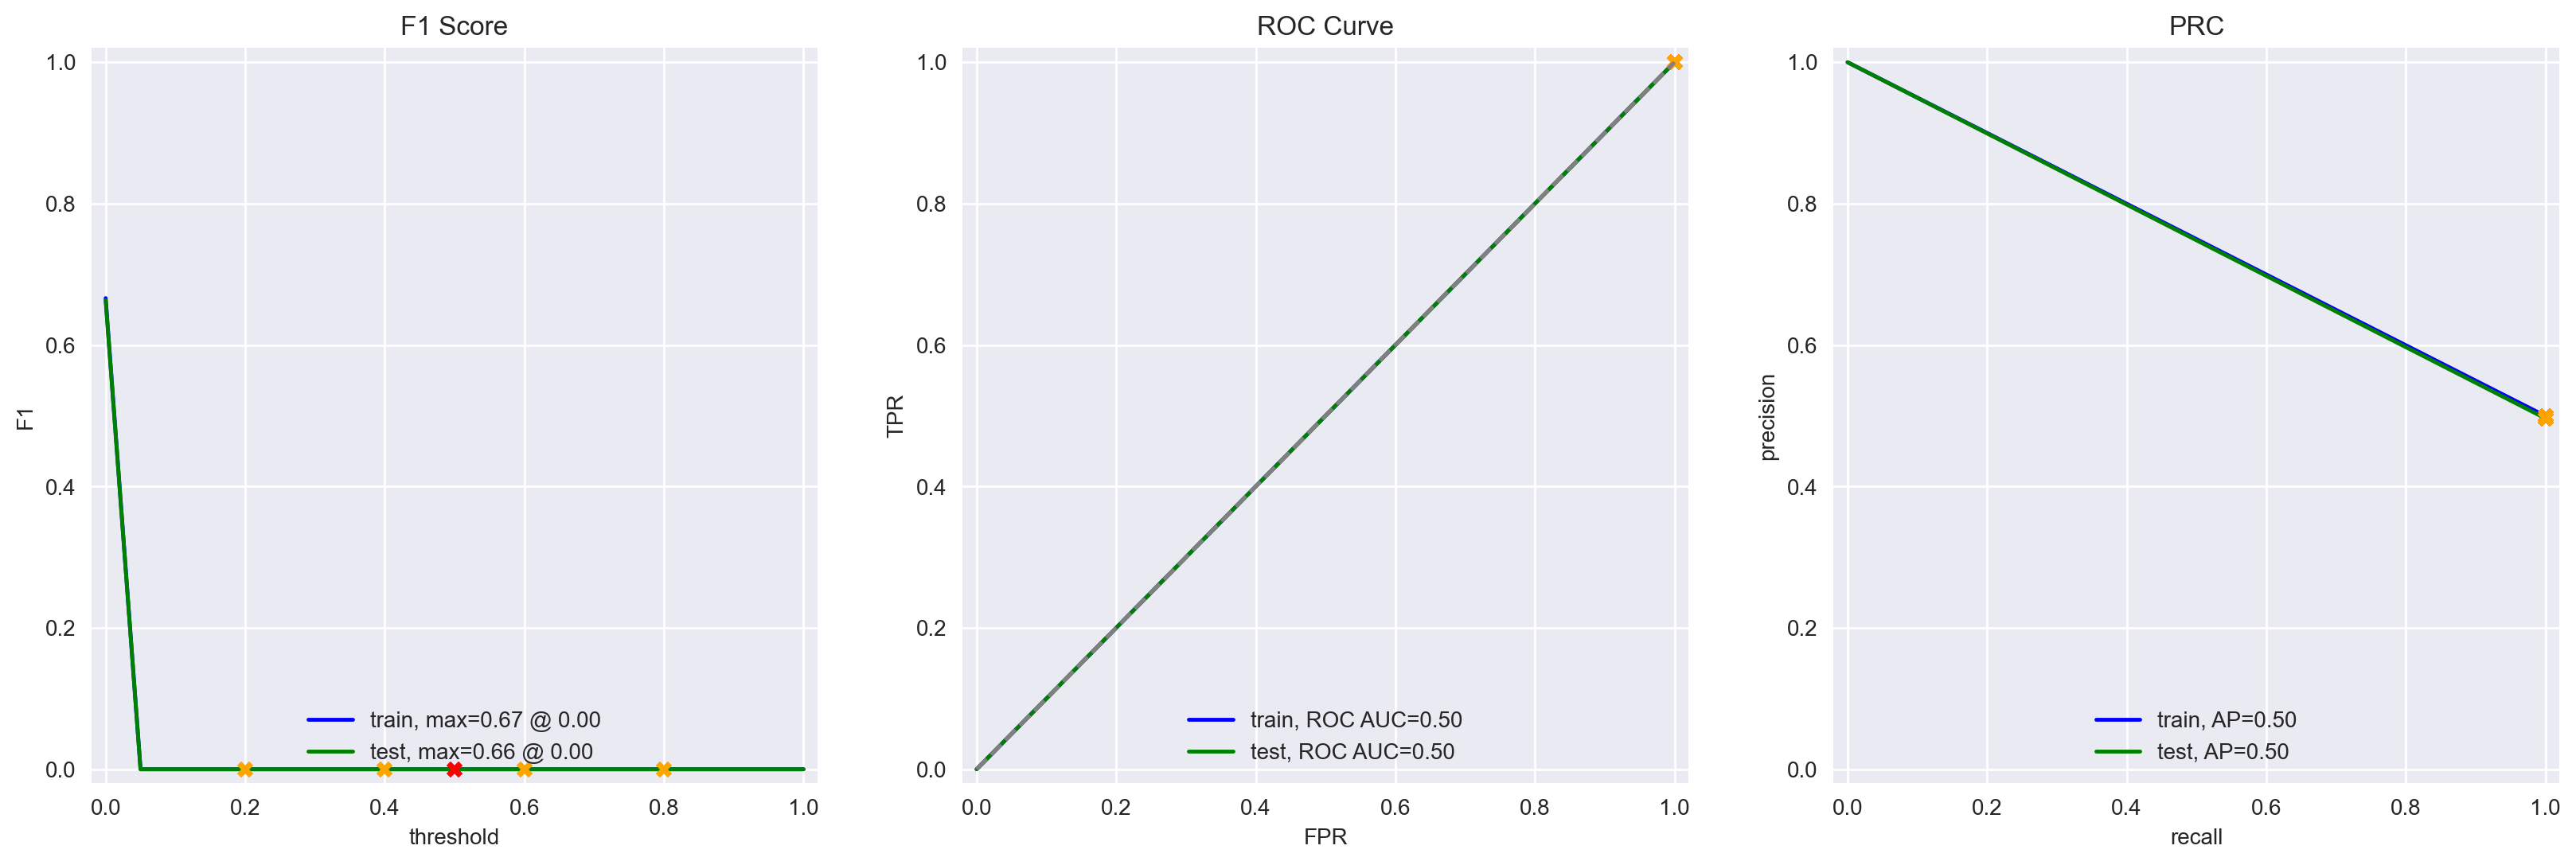

In [33]:
evaluate_model(dummy_clf, X_train, y_train, X_test, y_test)



There is a simple constant baseline.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test):
    # Make predictions using the model passed to this function
    y_pred = model.predict(X_test)
    
    # Print classification report and confusion matrix
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    # Optionally, you can return the metrics if you need to use them later
    return classification_report(y_test, y_pred, output_dict=True), confusion_matrix(y_test, y_pred)


In [35]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [36]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zoeyespinoza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
X = df_reviews['cleaned_review']
y = df_reviews['pos']

In [38]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))


In [40]:
X_train = tfidf_vectorizer.fit_transform(X_train_raw)
X_test = tfidf_vectorizer.transform(X_test_raw)

In [41]:
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

LogisticRegression()

In [42]:
y_pred = logistic_regression_model.predict(X_test)


In [43]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4769
           1       0.88      0.91      0.90      4698

    accuracy                           0.90      9467
   macro avg       0.90      0.90      0.90      9467
weighted avg       0.90      0.90      0.90      9467

[[4206  563]
 [ 424 4274]]


### Model 3 - spaCy, TF-IDF and LR

In [44]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [45]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [46]:
df_reviews['review'] = df_reviews['review'].fillna('')

In [47]:
tqdm.pandas()


df_reviews['processed_review'] = df_reviews['review'].progress_apply(text_preprocessing_3)


  0%|          | 0/47331 [00:00<?, ?it/s]

In [48]:
X_processed = df_reviews['processed_review']
y = df_reviews['pos']

In [49]:
X_train_processed, X_test_processed, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


In [50]:
tfidf_vectorizer_processed = TfidfVectorizer(stop_words=stopwords.words('english'))
X_train_processed_tfidf = tfidf_vectorizer_processed.fit_transform(X_train_processed)
X_test_processed_tfidf = tfidf_vectorizer_processed.transform(X_test_processed)

In [51]:
logistic_regression_processed = LogisticRegression()
logistic_regression_processed.fit(X_train_processed_tfidf, y_train)

LogisticRegression()

In [52]:
y_pred_processed = logistic_regression_processed.predict(X_test_processed_tfidf)
print(classification_report(y_test, y_pred_processed))
print(confusion_matrix(y_test, y_pred_processed))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      4769
           1       0.88      0.91      0.90      4698

    accuracy                           0.90      9467
   macro avg       0.90      0.90      0.90      9467
weighted avg       0.90      0.90      0.90      9467

[[4193  576]
 [ 406 4292]]


Precision: Similar to Model 1, with high precision (0.91 for class 0 and 0.88 for class 1), indicating a low rate of false positives.

Recall: Also high, (0.88 for class 0 and 0.91 for class 1), showing effectiveness in identifying positive cases.

F1 Score: Balanced F1 scores (0.90 for both classes) suggest a good equilibrium between precision and recall.

Accuracy: An overall accuracy of 0.90, on par with Model 1, indicating strong predictive capabilities.

Confusion Matrix:
For class 0: 4195 true positives and 574 false negatives.
For class 1: 4291 true positives and 407 false negatives.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [53]:
from lightgbm import LGBMClassifier

In [54]:
lgbm_classifier = LGBMClassifier()


In [55]:
lgbm_classifier.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 18918, number of negative: 18946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.824973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 739803
[LightGBM] [Info] Number of data points in the train set: 37864, number of used features: 15456
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499630 -> initscore=-0.001479
[LightGBM] [Info] Start training from score -0.001479


LGBMClassifier()

In [56]:
y_pred = lgbm_classifier.predict(X_test)

In [57]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [58]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8622583711841132
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      4769
           1       0.85      0.88      0.86      4698

    accuracy                           0.86      9467
   macro avg       0.86      0.86      0.86      9467
weighted avg       0.86      0.86      0.86      9467

Confusion Matrix:
 [[4044  725]
 [ 579 4119]]


Precision: High precision (0.87 for class 0 and 0.85 for class 1), similar to previous models.

Recall: Good recall (0.85 for class 0 and 0.88 for class 1), indicating effectiveness in identifying positive cases.

F1 Score: Balanced F1 scores (0.86 for both classes), showing a good balance between precision and recall.

Accuracy: An overall accuracy of 0.86, slightly lower than Models 1 and 3.

Confusion Matrix:
For class 0: 4044 true positives and 725 false negatives.
For class 1: 4119 true positives and 579 false negatives.

## Conclusion

**Performance against Baseline (Model 0):** Model 4, like the other models, is significantly better than the baseline Model 0 in every aspect. It demonstrates the value of complex models over a simple constant baseline.

**Comparison with Models 1 and 3:** Model 4 has a slightly lower accuracy (0.86) compared to Models 1 and 3 (0.90). This might be due to the differences in the underlying algorithms (LGBM vs. Logistic Regression). The precision, recall, and F1 scores are also slightly lower but still reflect a strong model performance.

**Model Characteristics:** The use of LightGBM might offer advantages in terms of training speed and handling large datasets, despite a slight drop in performance metrics. This trade-off could be beneficial in certain applications where scalability and speed are more critical.

**Performance of Model 4:** This model showcases the application of a gradient boosting framework in text classification tasks, providing a competitive alternative to logistic regression-based models. While it slightly underperforms in accuracy compared to Models 1 and 3, it still greatly surpasses the baseline and may offer practical advantages in specific scenarios. The choice between logistic regression and gradient boosting models would depend on the specific requirements of the task, such as the need for speed and scalability versus the highest possible accuracy.